# Exercise 3
Due:  Tue November 12, 8:00am

Names of all participants working on this exercise:
Davide Mattioli
Pablo Jahnen



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch_geometric as pyg
import ogb.graphproppred
import ogb.graphproppred.mol_encoder
from tqdm import tqdm
import torch_scatter
import sklearn

In [3]:
# find device
if torch.cuda.is_available(): # NVIDIA
    device = torch.device('cuda')
elif torch.backends.mps.is_available(): # apple M1/M2
    device = torch.device('mps') 
else:
    device = torch.device('cpu')
device

device(type='cuda')

ppa = ogb.graphproppred.PygGraphPropPredDataset(name="ogbg-ppa")

In [4]:
dataset = pyg.datasets.LRGBDataset(root='dataset/peptides-func', name="Peptides-func")
peptides_train = pyg.datasets.LRGBDataset(root='dataset/peptides-func', name="Peptides-func", split="train")
peptides_val   = pyg.datasets.LRGBDataset(root='dataset/peptides-func', name="Peptides-func", split="val")
peptides_test  = pyg.datasets.LRGBDataset(root='dataset/peptides-func', name="Peptides-func", split="test")

batch_size = 32
train_loader = pyg.loader.DataLoader(peptides_train, batch_size = batch_size, shuffle = True)
val_loader = pyg.loader.DataLoader(peptides_val, batch_size = batch_size, shuffle = True)
test_loader = pyg.loader.DataLoader(peptides_test, batch_size = batch_size, shuffle = True)



Extracting dataset\peptides-func\peptidesfunc.zip
Processing...
Processing test dataset: 100%|██████████| 2331/2331 [00:00<00:00, 50227.19it/s]
Done!


In this exercise, we will expand our sparse GNNs. For reference, I attached my version of the GCNLayer module (for those who did have problems with exercise 2).

For next week please:
1. Implement virtual nodes
2. Implement GINE (GIN+Edge features) based on the sparse implementation from Exercise 2
3. Test everything (especially the effects of virtual nodes and edge features) on peptides-func.
4. Draw the molecule peptides_train[0]

Expected performance of the GNNs would be to reach more than 0.6 AP. (0.68 is within reach using simple and small networks).

In [5]:
class GCNLayer(torch.nn.Module):
    def __init__(self, in_features: int, out_features: int, activation=torch.nn.functional.relu):
        super(GCNLayer, self).__init__()
        self.activation = activation
        self.W: torch.Tensor = torch.nn.Parameter(torch.zeros(in_features, out_features))
        torch.nn.init.kaiming_normal_(self.W) 

    def forward(self, H: torch.Tensor, edge_index: torch.Tensor):
        out = H.clone()
        new_H = torch_scatter.scatter_add(H[edge_index[0]], edge_index[1], dim=0, dim_size=out.shape[0])
        out = out + new_H
        out = out.matmul(self.W)
        if self.activation:
            out = self.activation(out)
        return out

In [6]:
def evaluate(loader,model):
    
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(next(model.parameters()).device)
            outputs = model(batch.x, batch.edge_index, batch.batch)
            y_pred.extend(outputs.cpu().numpy())
            y_true.extend(batch.y.cpu().numpy())
    
    ap_score = sklearn.metrics.average_precision_score(y_true, y_pred)
    # print(f"Average Precision Score: {ap_score:.4f}")
    return ap_score

In [7]:
class GINELayer(torch.nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super(GINELayer, self).__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(in_features, out_features),
            torch.nn.ReLU(),
            torch.nn.Linear(out_features, out_features)
        )
        self.edge_mlp = torch.nn.Linear(in_features, out_features)

    def forward(self, H: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor):
        # Aggregate messages with edge features
        edge_messages = self.edge_mlp(edge_attr)
        messages = H[edge_index[0]] + edge_messages
        aggregated = torch_scatter.scatter_add(messages, edge_index[1], dim=0, dim_size=H.shape[0])
        return self.mlp(aggregated)


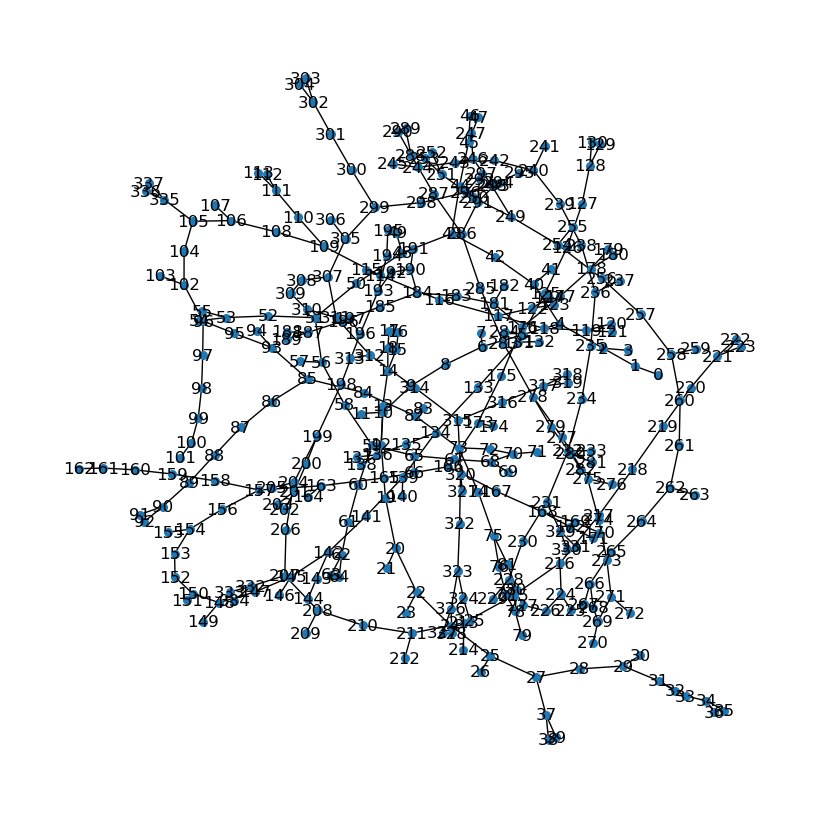

In [8]:
import networkx as nx
import matplotlib.pyplot as plt


data = peptides_train[0]
G = pyg.utils.to_networkx(data, to_undirected=True)

plt.figure(figsize=(8, 8))
nx.draw(G, node_size=30, with_labels=True)
plt.show()


In [13]:
# Set up model, optimizer, and loss function
model = SimpleGNN(in_features=dataset.num_node_features, hidden_features=64, out_features=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch).squeeze(-1)
        loss = loss_fn(out, batch.y.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

    # Evaluate on the validation set
    val_ap = evaluate(val_loader, model)
    print(f"Validation Average Precision Score: {val_ap:.4f}")

# Evaluate on the test set after training
test_ap = evaluate(test_loader, model)
print(f"Test Average Precision Score: {test_ap:.4f}")
